In [8]:
import matplotlib.pyplot as plt

from usbmd import setup, Config
from usbmd.data import load_usbmd_file
from usbmd.ops_v2 import Pipeline
from usbmd.display import to_8bit

In [2]:
# choose your config file
# all necessary settings should be in the config file
config_path = "../../configs/config_usbmd_carotid.yaml"

# setup function handles local data paths, default config settings and GPU usage
# make sure to create your own users.yaml using usbmd/datapaths.py
users_paths = "../../users.yaml"
config = setup(config_path, users_paths, create_user=True)

# we now manually point to our data
data_root = config.data.user.data_root
user = config.data.user.username

print(f"\n🔔 Hi {user}! You are using data from {data_root}\n")

# dataset_folder: USBMD_datasets/2023_USBMD_carotid/HDF5
dataset_folder = config.data.dataset_folder

# file_path: 2_cross_bifur_right_0000.hdf5
file = config.data.file_path
data_path = data_root / dataset_folder / file

assert data_path.exists(), f"🚫 Data path does not exist: {data_path}, please check your paths"

usbmd: Using config file: ../../configs/config_usbmd_carotid.yaml
usbmd: Git branch and commit: feature/interface-update=609c9cf265dca113e5b8a7526afc6967f663294b
usbmd: Data paths set successfully.
usbmd: Here's a summary of your data paths:
	data_root: /mnt/z/Ultrasound-BMd/data
	repo_root: /ultrasound-toolbox/usbmd/datapaths.py
	output: /mnt/z/Ultrasound-BMd/pretrained
	system: linux
	username: devcontainer15
	hostname: 453462d5764f

-------------------GPU settings-------------------
     memory
GPU        
0      2578
1     11011
2     11011
3      2550
4     11011
5       942
6       948
7       658
Selected GPU 1 with Free Memory: 11011.00 MiB
Hiding GPUs [0, 2, 3, 4, 5, 6, 7] from the system.
--------------------------------------------------

🔔 Hi devcontainer15! You are using data from /mnt/z/Ultrasound-BMd/data



In [3]:
# only 1 frame is loaded for this example
selected_frames = [0]

# loading a file manually using `load_usbmd_file`
data, scan, probe = load_usbmd_file(
    data_path, frames=selected_frames, config=config, data_type="raw_data"
)

# index the first frame
data_frame = data[0]

usbmd: WARNING The probe geometry in the data file does not match the probe geometry of the probe. The probe geometry has been updated to match the data file.
usbmd: WARNING width/Nx = 0.0001235 < wvln/2 = 9.856e-05. Consider increasing scan.Nx to 377 or more.
usbmd: WARNING depth/Nz = 0.0001072 < wvln/2 = 0.0000986. Consider increasing scan.Nz to 544 or more.


In [4]:
# showing the current pipeline from config
print(config.pipeline)

<Config {'operations': [{'name': 'patched_grid', 'params': {'operations': [{'name': 'tof_correction'}, {'name': 'pfield_weighting'}, {'name': 'delay_and_sum'}], 'num_patches': 100}}, {'name': 'envelope_detect'}, {'name': 'normalize'}, {'name': 'log_compress'}]}>


usbmd: Computing pressure field for all transmits
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/transmits


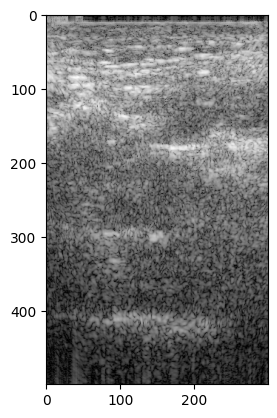

In [ ]:
pipeline_config = Config({
    "pipeline": {
        "operations": [
            {
                "name": "patched_grid",
                "params": {
                    "operations": [
                        {"name": "tof_correction"},
                        {"name": "pfield_weighting"},
                        {"name": "delay_and_sum"}
                    ],
                    "num_patches": 100
                }
            },
            {"name": "envelope_detect"},
            {"name": "normalize"},
            {"name": "log_compress"}
        ]
    }
}
)

pipeline = Pipeline.from_config(pipeline_config, with_batch_dim=False, jit_options="pipeline")

input_key = pipeline.key
output_key = pipeline.output_key

inputs = {input_key: data_frame}

outputs = pipeline(scan, probe, config, **inputs)

image = outputs[output_key]

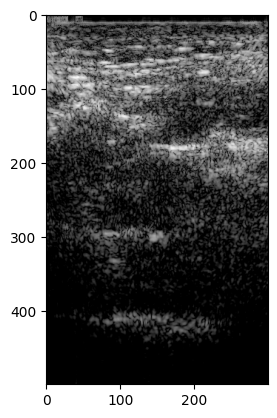

In [9]:
image_display = to_8bit(image, config.data.dynamic_range)

plt.figure()
plt.imshow(image_display, cmap="gray")

In [12]:
from usbmd.ops_v2 import PatchedGrid, EnvelopeDetect, Normalize, LogCompress, TOFCorrection, PfieldWeighting, DelayAndSum

pipeline = Pipeline(
    operations = [

        PatchedGrid(
            operations = [
                TOFCorrection(),
                PfieldWeighting(),
                DelayAndSum()
            ],
            num_patches = 100
        ),
        EnvelopeDetect(),
        Normalize(),
        LogCompress(),
    ],
    with_batch_dim = False,
    jit_options = "pipeline"
)

outputs = pipeline(scan, probe, config, **inputs)

image = outputs[output_key]

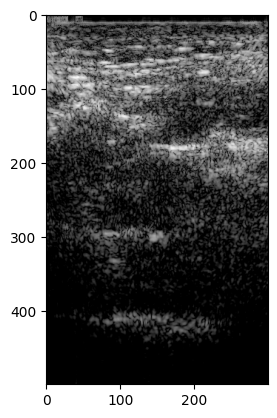

In [13]:
image_display = to_8bit(image, config.data.dynamic_range)

plt.figure()
plt.imshow(image_display, cmap="gray")